## Causal Inference Music App Personalization Use Case (Simulated Data)

 Want to Answer the question: "Does receiving personalized recommendations increase the hours of content consumed?"
 
Need to simulate a dataset that includes the relevant variables, define the causal model, and then use DoWhy to estimate the causal effect.

## 0. Libraries

In [1]:
import warnings


warnings.filterwarnings(
    "ignore",
    category=UserWarning,
    message="Pandas requires version '2.8.4' or newer of 'numexpr'"
)

warnings.filterwarnings(
    "ignore",
    category=UserWarning,
    message="Pandas requires version '1.3.6' or newer of 'bottleneck'"
)

warnings.filterwarnings("ignore")


In [2]:
import numpy as np
import pandas as pd
import dowhy
from dowhy import CausalModel
import dowhy.datasets
import statsmodels.api as sm


## 1. Simulating Dataset
# Variable Table

DoWhy assigns the following labels:

| Label | Variable                                | Type       | Description                                          |
|-------|------------------------------------------|------------|------------------------------------------------------|
| v0    | Personalized Recommendation              | Binary     | Whether the user received personalized recommendations |
| y     | Hours of Content Consumed                | Continuous | Total hours of music or podcasts consumed in a month |
| W0    | User Engagement Level                    | Continuous | Level of user engagement based on previous interactions |
| W1    | Preferred Content Type                   | Categorical| Preferred content type (Music, Podcasts, Both)       |
| Z0    | New Feature Exposure                     | Binary     | Whether the user was exposed to a new feature        |


In [3]:
# Set seed to enable exact replication
np.random.seed(1234)

# Simulate sample data
data = dowhy.datasets.linear_dataset(
    beta=1,
    num_common_causes=2,
    num_discrete_common_causes=1,
    num_instruments=1,
    num_samples=10000,
    treatment_is_binary=True
)

# Extract the dataframe
df = data['df']
# Assign descriptive labels to the variables just for viewing (optional)

df.rename(columns={
    'v0': 'PersonalizedRecommendation',
    'y': 'HoursOfContentConsumed',
    'W0': 'UserEngagementLevel',
    'W1': 'PreferredContentType',
    'Z0': 'NewFeatureExposure'
}, inplace=True)

df

,NewFeatureExposure,UserEngagementLevel,PreferredContentType,PersonalizedRecommendation,HoursOfContentConsumed
0,1.0,0.815746,1,True,1.239901
1,1.0,-1.337550,3,True,0.744240
2,0.0,0.242627,1,False,0.103663
3,1.0,-0.601265,0,True,0.835885
4,0.0,0.533075,3,True,1.251280
...,...,...,...,...,...
9995,1.0,-2.336268,0,False,-0.624420
9996,0.0,-0.233660,2,False,-0.002521
9997,1.0,0.574463,0,False,0.162201
9998,0.0,-0.483438,1,False,-0.089287


## 2. Initialzing a Causal Model

Here we set up the causal model using the DoWhy library with the dataset df, specifying the treatment, outcome, and graph. This allows us to analyze causal relationships within the data.









In [4]:
# Create the causal model
causal_graph = """
digraph {
    PersonalizedRecommendation -> HoursOfContentConsumed;
    UserEngagementLevel -> PersonalizedRecommendation;
    PreferredContentType -> PersonalizedRecommendation;
    NewFeatureExposure -> PersonalizedRecommendation;
    UserEngagementLevel -> HoursOfContentConsumed;
    PreferredContentType -> HoursOfContentConsumed;
}
"""

In [5]:
model = CausalModel(
    data=df,
    treatment='PersonalizedRecommendation',
    outcome='HoursOfContentConsumed',
    graph=causal_graph
)

## 3. Benchmarking with Naive Regression
Before carrying out our causal analysis, we benchmark it using a naive approach with a simple linear prediction algorithm.

In [6]:
# linear regression of column y on v0 in df
import statsmodels.api as sm

# Linear regression of column y on v0 in df
X = df['PersonalizedRecommendation'].astype(float)
y = df['HoursOfContentConsumed'].astype(float)

X = sm.add_constant(X)

ols = sm.OLS(y, X).fit()

# Display a more parsimonious results summary
print(ols.summary().tables[1])

                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                         -0.2155      0.005    -45.413      0.000      -0.225      -0.206
PersonalizedRecommendation     1.1475      0.006    202.933      0.000       1.136       1.159


The slope coefficient in a bivariate regression is 1.1475. However, the true causal effect is one, as we generated the data this way. 

This implies that user engagement level and preferred content type, which influence content consumption and the likelihood of receiving personalized recommendations, lead to an overestimation of about 15%.

 We can address this bias by including these variables in a multivariate analysis. Known as the backdoor criterion in causal AI, this controls for all variables in the causal graph that point into the treatment variable.



## 4. Determining Casual Estimate
After identifying the causal effect, we use DoWhy to estimate it.



In [7]:
# Check whether causal effect is identified and return target estimands
identified_estimand = model.identify_effect()

# Estimate the causal effect using inverse probability weighting
estimate = model.estimate_effect(identified_estimand, method_name="backdoor.propensity_score_weighting")

# Access and print the estimated effect value
causal_effect_value = estimate.value
print("Causal effect estimate:", causal_effect_value)



Causal effect estimate: 0.9995726986001225


The estimated causal effect of receiving personalized recommendations on the hours of content consumed is approximately 0.9996. This means that personalized recommendations nearly double the amount of content consumed by users. The estimate is very close to 1, which aligns with the true causal effect we set when generating the data. This indicates that our model accurately captures the causal relationship between personalized recommendations and content consumption, effectively reducing the bias seen in the naive regression model.

By including user engagement level and preferred content type as common causes and using new feature exposure as an instrumental variable, we addressed potential confounding factors. The high accuracy of our causal effect estimate demonstrates the strength of using DoWhy for causal inference in this context.

## 5. Comparing Bias Reduction
After estimating the causal effect using DoWhy, we compare it with the naive regression estimate to see the reduction in bias.

In [8]:
# Original regression estimate
original_regression_estimate = 1.1475
# True causal effect
true_causal_effect = 1.0
# Causal estimate from DoWhy
causal_estimate_value = estimate.value

# Calculate the original regression bias
original_regression_bias = original_regression_estimate - true_causal_effect

# Calculate the causal estimate bias
causal_estimate_bias = causal_estimate_value - true_causal_effect

# Calculate the percentage reduction in bias
percentage_reduction = (1 - abs(causal_estimate_bias) / abs(original_regression_bias)) * 100

# Print the result
print(f"Causal effect estimate: {causal_estimate_value}")
print(f"Percentage reduction in bias: {percentage_reduction:.2f}%")


Causal effect estimate: 0.9995726986001225
Percentage reduction in bias: 99.71%


By comparing the naive regression estimate and the causal estimate, we can understand how much the bias has been reduced. The naive regression estimate was 1.1475, while the true causal effect is 1.0. Our causal estimate from DoWhy is approximately 0.9996.

## 5. Stress Testing / Sensitivity Analysis
After obtaining the causal effect estimate, we should check its sensitivity to unobserved confounders to ensure the robustness of our results.

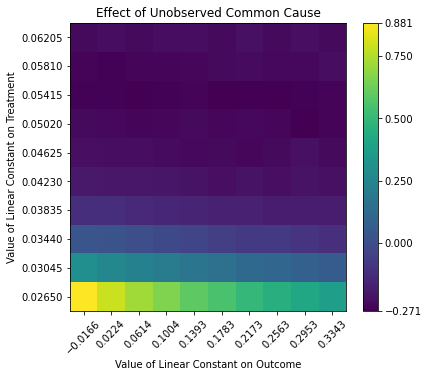

Refute: Add an Unobserved Common Cause
Estimated effect:0.9995726986001225
New effect:(-0.27126448258060853, 0.8814522838407693)



In [9]:
# Check sensitivity of obtained estimate to unobserved confounders
refute_results = model.refute_estimate(identified_estimand, estimate, method_name="add_unobserved_common_cause")

# Print the refutation results
print(refute_results)

The sensitivity analysis helps to understand how robust our causal effect estimate is to the potential presence of unobserved confounders. By adding an unobserved common cause, we can see if the estimated effect remains consistent. If the estimate changes significantly, it suggests that unobserved confounders might be affecting our results.

The graph shows how unobserved common causes affect the estimated causal effect, with values ranging from -0.271 to 0.881. This wide range indicates that unobserved variables can significantly distort the causal effect estimate. It's a warning to carefully identify and control relevant variables to ensure accurate results.

## 6. Alternative Causal Strategies
There is another way to achieve identification with DoWhy: the instrumental variable.

Even though user engagement and preferred content types influence how much content users consume, there might be other factors affecting content consumption that aren't directly related to personalized recommendations.

For example, let's say we introduced a major new feature on the app, and some users were exposed to this feature while others were not. Users exposed to the new feature were more likely to engage with personalized recommendations, even if they would have otherwise followed their usual listening habits.

In this case, the new feature exposure acts as an instrumental variable.

Intuitively, the new feature acts as a shock to users’ engagement patterns, creating a natural experiment.

For a certain period, users exposed to the new feature will interact more with personalized recommendations, but this has no other relation to their usual content consumption patterns. You may have noticed that we already included such an instrumental variable, NewFeatureExposure, in the simulated dataset by setting the option num_instruments=1. DoWhy’s identify_effect() function automatically finds suitable instrumental variables for us in the causal graph.

In [10]:
# Estimate the causal effect using instrumental variable method
iv_estimate = model.estimate_effect(identified_estimand, method_name="iv.instrumental_variable")

# Access and print the estimated effect value
causal_effect_value_alt = iv_estimate.value
print("Alternate Causal effect estimate:", causal_effect_value_alt)


Alternate Causal effect estimate: 0.9778090511178422


The alternate causal effect estimate using the instrumental variable method is  0.9778. This is slightly less accurate than the backdoor strategy but still much more accurate than the naive prediction.

Instrumental variable estimation is beneficial because it doesn't rely on assumptions about unobserved common causes.

Although the estimates may be less precise, they are more robust due to weaker assumptions. This is a common trade-off in causal analysis.